In [62]:
# Importing essential libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import rcParams as rcP

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

%matplotlib inline

## Loading dataset

In [63]:
# Loading the dataset
df = pd.read_csv("data/data.csv")
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [64]:
# Exploring the dataset
df.shape

(13320, 9)

In [65]:
# Exploring the dataset
df.groupby("area_type")["area_type"].agg("count")

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

In [66]:
# Exploring the dataset
df.groupby("availability")["availability"].agg("count")

availability
14-Jul                      1
14-Nov                      1
15-Aug                      1
15-Dec                      1
15-Jun                      1
                        ...  
22-Mar                      3
22-May                     10
22-Nov                      2
Immediate Possession       16
Ready To Move           10581
Name: availability, Length: 81, dtype: int64

In [67]:
# Exploring the dataset
df.groupby("size")["size"].agg("count")

size
1 BHK          538
1 Bedroom      105
1 RK            13
10 BHK           2
10 Bedroom      12
11 BHK           2
11 Bedroom       2
12 Bedroom       1
13 BHK           1
14 BHK           1
16 BHK           1
18 Bedroom       1
19 BHK           1
2 BHK         5199
2 Bedroom      329
27 BHK           1
3 BHK         4310
3 Bedroom      547
4 BHK          591
4 Bedroom      826
43 Bedroom       1
5 BHK           59
5 Bedroom      297
6 BHK           30
6 Bedroom      191
7 BHK           17
7 Bedroom       83
8 BHK            5
8 Bedroom       84
9 BHK            8
9 Bedroom       46
Name: size, dtype: int64

In [68]:
# Removing the columns of society
df = df.drop("society", axis="columns")
df.head()

,area_type,availability,location,size,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,1200,2.0,1.0,51.00


## Data Cleaning Process

In [69]:
# Data Cleaning
# Checking the null values in the dataset
df.isnull().sum()

area_type         0
availability      0
location          1
size             16
total_sqft        0
bath             73
balcony         609
price             0
dtype: int64

In [70]:
# Applying median to the balcony and bath column
from math import floor

balcony_median = float(floor(df.balcony.median()))
bath_median = float(floor(df.bath.median()))

df.balcony = df.balcony.fillna(balcony_median)
df.bath = df.bath.fillna(bath_median)

In [71]:
# Checking the null values in the dataset again
df.isnull().sum()

area_type        0
availability     0
location         1
size            16
total_sqft       0
bath             0
balcony          0
price            0
dtype: int64

In [72]:
# Dropping the rows with null values because the dataset is huge as compared to null values.
df = df.dropna()
df.isnull().sum()

area_type       0
availability    0
location        0
size            0
total_sqft      0
bath            0
balcony         0
price           0
dtype: int64

In [73]:
# Converting the size column to bhk
df["bhk"] = df["size"].apply(lambda x: int(x.split(" ")[0]))
df = df.drop("size", axis="columns")
df.groupby("bhk")["bhk"].agg("count")

bhk
1      656
2     5528
3     4856
4     1417
5      356
6      221
7      100
8       89
9       54
10      14
11       4
12       1
13       1
14       1
16       1
18       1
19       1
27       1
43       1
Name: bhk, dtype: int64

In [74]:
# Exploring the total_sqft column
df.total_sqft.unique()

array(['1056', '2600', '1440', ..., '1133 - 1384', '774', '4689'],
      dtype=object)

In [75]:
# Since the total_sqft contains range values such as 1133-1384, lets filter out these values
def isFloat(x):
    try:
        float(x)
    except:
        return False
    return True

In [76]:
# Displaying all the rows that are not integers
df[~df["total_sqft"].apply(isFloat)]

,area_type,availability,location,total_sqft,bath,balcony,price,bhk
30,Super built-up Area,19-Dec,Yelahanka,2100 - 2850,4.0,0.0,186.000,4
56,Built-up Area,20-Feb,Devanahalli,3010 - 3410,2.0,2.0,192.000,4
81,Built-up Area,18-Oct,Hennur Road,2957 - 3450,2.0,2.0,224.500,4
122,Super built-up Area,18-Mar,Hebbal,3067 - 8156,4.0,0.0,477.000,4
137,Super built-up Area,19-Mar,8th Phase JP Nagar,1042 - 1105,2.0,0.0,54.005,2
...,...,...,...,...,...,...,...,...
12990,Super built-up Area,18-May,Talaghattapura,1804 - 2273,3.0,0.0,122.000,3
13059,Super built-up Area,Ready To Move,Harlur,1200 - 1470,2.0,0.0,72.760,2
13240,Super built-up Area,Ready To Move,Devanahalli,1020 - 1130,2.0,2.0,52.570,1
13265,Super built-up Area,20-Sep,Hoodi,1133 - 1384,2.0,0.0,59.135,2


In [77]:
# Converting the range values to integer values and removing other types of error
def convert_sqft_to_num(x):
    tokens = x.split("-")
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None

In [78]:
df["new_total_sqft"] = df.total_sqft.apply(convert_sqft_to_num)
df = df.drop("total_sqft", axis="columns")
df.head()

,area_type,availability,location,bath,balcony,price,bhk,new_total_sqft
0,Super built-up Area,19-Dec,Electronic City Phase II,2.0,1.0,39.07,2,1056.0
1,Plot Area,Ready To Move,Chikka Tirupathi,5.0,3.0,120.00,4,2600.0
2,Built-up Area,Ready To Move,Uttarahalli,2.0,3.0,62.00,3,1440.0
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3.0,1.0,95.00,3,1521.0
4,Super built-up Area,Ready To Move,Kothanur,2.0,1.0,51.00,2,1200.0


In [79]:
# Removing the rows in new_total_sqft column that hase None values
df.isna().sum()

area_type          0
availability       0
location           0
bath               0
balcony            0
price              0
bhk                0
new_total_sqft    46
dtype: int64

In [80]:
# Removing the rows in new_total_sqft column that hase None values
df = df.dropna()
df.isna().sum()

area_type         0
availability      0
location          0
bath              0
balcony           0
price             0
bhk               0
new_total_sqft    0
dtype: int64

## Feature Engineering

In [81]:
# Adding a new column of price_per_sqft
df1 = df.copy()

# In our dataset the price column is in Lakhs
df1["price_per_sqft"] = (df1["price"]*100000)/df1["new_total_sqft"]
df1.head()

,area_type,availability,location,bath,balcony,price,bhk,new_total_sqft,price_per_sqft
0,Super built-up Area,19-Dec,Electronic City Phase II,2.0,1.0,39.07,2,1056.0,3699.810606
1,Plot Area,Ready To Move,Chikka Tirupathi,5.0,3.0,120.00,4,2600.0,4615.384615
2,Built-up Area,Ready To Move,Uttarahalli,2.0,3.0,62.00,3,1440.0,4305.555556
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3.0,1.0,95.00,3,1521.0,6245.890861
4,Super built-up Area,Ready To Move,Kothanur,2.0,1.0,51.00,2,1200.0,4250.000000


In [82]:
# Checking unique values of "location" column
locations = list(df["location"].unique())
print(len(locations))

1298


In [83]:
# Removing the extra spaces at the end
df1.location = df1.location.apply(lambda x: x.strip())

# Calulating all the unqiue values in "location" column
location_stats = df1.groupby("location")["location"].agg("count").sort_values(ascending=False)
location_stats

location
Whitefield               538
Sarjapur  Road           397
Electronic City          304
Kanakpura Road           271
Thanisandra              236
                        ... 
1 Giri Nagar               1
Kanakapura Road,           1
Kanakapura main  Road      1
Kannur                     1
whitefiled                 1
Name: location, Length: 1287, dtype: int64

In [84]:
# Checking locations with less than 10 values
print(len(location_stats[location_stats<=10]), len(df1.location.unique()))

1047 1287


In [85]:
df1.head()

,area_type,availability,location,bath,balcony,price,bhk,new_total_sqft,price_per_sqft
0,Super built-up Area,19-Dec,Electronic City Phase II,2.0,1.0,39.07,2,1056.0,3699.810606
1,Plot Area,Ready To Move,Chikka Tirupathi,5.0,3.0,120.00,4,2600.0,4615.384615
2,Built-up Area,Ready To Move,Uttarahalli,2.0,3.0,62.00,3,1440.0,4305.555556
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3.0,1.0,95.00,3,1521.0,6245.890861
4,Super built-up Area,Ready To Move,Kothanur,2.0,1.0,51.00,2,1200.0,4250.000000


In [86]:
# Labelling the locations with less than or equal to 10 occurences to "other"
locations_less_than_10 = location_stats[location_stats<=10]

df1.location = df1.location.apply(lambda x: "other" if x in locations_less_than_10 else x)
len(df1.location.unique())

241

In [87]:
# Checking the unique values in "availability column"
df1.groupby("availability")["availability"].agg("count").sort_values(ascending=False)

availability
Ready To Move    10541
18-Dec             306
18-May             294
18-Apr             271
18-Aug             199
                 ...  
16-Oct               1
16-Nov               1
16-Jul               1
16-Jan               1
14-Jul               1
Name: availability, Length: 80, dtype: int64

In [88]:
# Labelling the dates into Not Ready
dates = df1.groupby("availability")["availability"].agg("count").sort_values(ascending=False)

dates_not_ready = dates[dates<10000]
df1.availability = df1.availability.apply(lambda x: "Not Ready" if x in dates_not_ready else x)

len(df1.availability.unique())

2

In [89]:
df1.head()

,area_type,availability,location,bath,balcony,price,bhk,new_total_sqft,price_per_sqft
0,Super built-up Area,Not Ready,Electronic City Phase II,2.0,1.0,39.07,2,1056.0,3699.810606
1,Plot Area,Ready To Move,Chikka Tirupathi,5.0,3.0,120.00,4,2600.0,4615.384615
2,Built-up Area,Ready To Move,Uttarahalli,2.0,3.0,62.00,3,1440.0,4305.555556
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3.0,1.0,95.00,3,1521.0,6245.890861
4,Super built-up Area,Ready To Move,Kothanur,2.0,1.0,51.00,2,1200.0,4250.000000


In [90]:
# Checking the unique values in "area_type" column
df1.groupby("area_type")["area_type"].agg("count").sort_values(ascending=False)

area_type
Super built-up  Area    8778
Built-up  Area          2402
Plot  Area              1991
Carpet  Area              86
Name: area_type, dtype: int64

## Removing Outliers

In [91]:
# Removing the rows that have 1 Room for less than 300sqft

df2 = df1[~(df1.new_total_sqft/df1.bhk<300)]
print(len(df2), len(df1))

12513 13257


In [92]:
df2.price_per_sqft.describe()

count     12513.000000
mean       6307.441644
std        4160.931610
min         267.829813
25%        4210.526316
50%        5295.007564
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

In [93]:
# Since there is a wide range for "price_per_sqft" column with min = Rs.267/sqft till max = Rs. 127470/sqft, we remove the extreme ends using the SD
def remove_pps_outliers(df):
    
    df_out = pd.DataFrame()
    
    for key, sub_df in df.groupby("location"):
        m = np.mean(sub_df.price_per_sqft)
        sd = np.std(sub_df.price_per_sqft)
        reduce_df = sub_df[(sub_df.price_per_sqft>(m-sd)) & (sub_df.price_per_sqft<(m+sd))]
        df_out = pd.concat([df_out, reduce_df], ignore_index=True)
    
    return df_out

df3 = remove_pps_outliers(df2)
print(len(df2), len(df3))

12513 10288


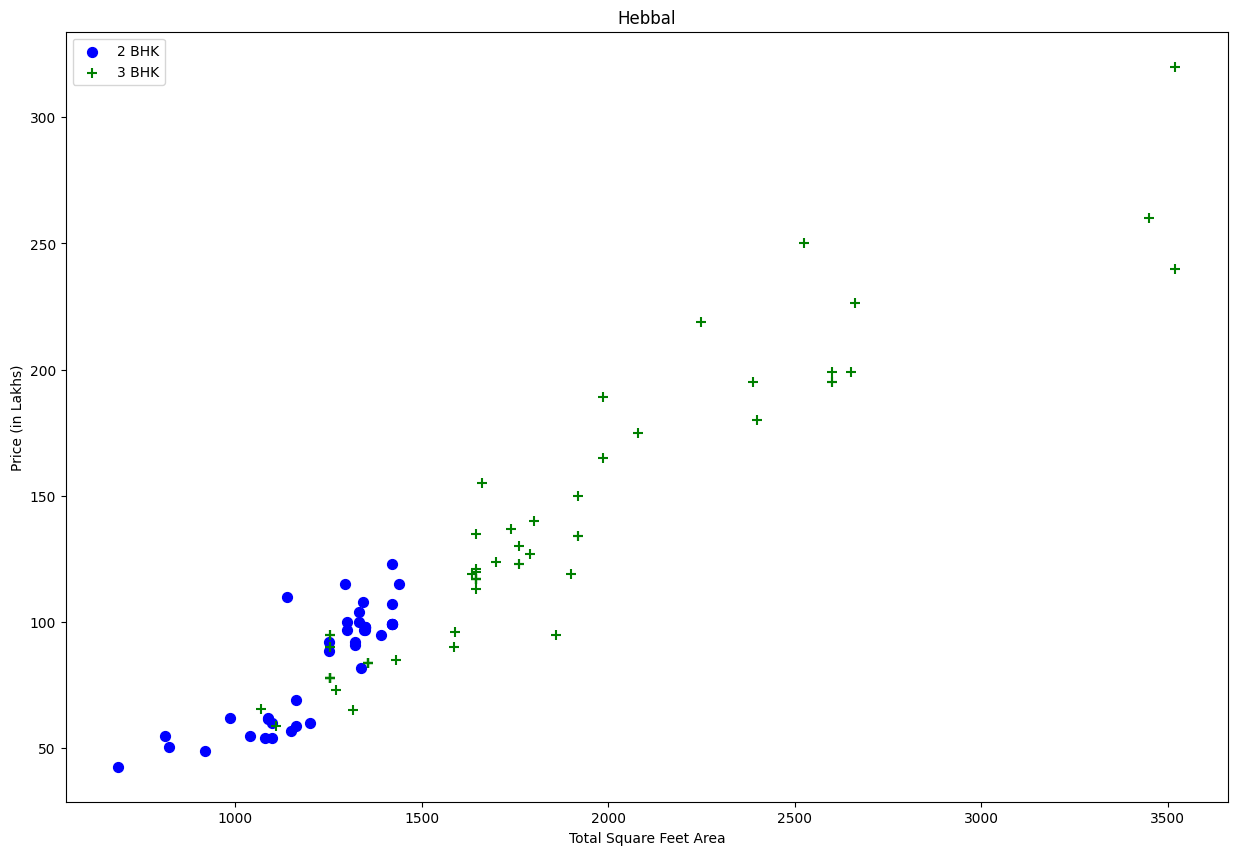

In [94]:
def plot_scatter_chart(df, location):
    bhk2 = df[(df.location == location) & (df.bhk == 2)]
    bhk3 = df[(df.location == location) & (df.bhk == 3)]
    rcP["figure.figsize"] = (15,10)
    plt.scatter(bhk2.new_total_sqft, bhk2.price, color="blue", label="2 BHK", s=50)
    plt.scatter(bhk3.new_total_sqft, bhk3.price, color="green", marker="+", label="3 BHK", s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (in Lakhs)")
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(df3, "Hebbal")

In [95]:
# Here we observe that 3 BHK cost that same as 2 BHK in "Hebbal" location hence removing such outliers is necessary
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    
    for location, location_df in df.groupby("location"):
        bhk_stats = {}
        
        for bhk, bhk_df in location_df.groupby("bhk"):
            bhk_stats[bhk] = {
                "mean": np.mean(bhk_df.price_per_sqft),
                "std": np.std(bhk_df.price_per_sqft),
                "count": bhk_df.shape[0]
            }
        
        for bhk, bhk_df in location_df.groupby("bhk"):
            stats = bhk_stats.get(bhk-1)
            if stats and stats["count"]>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats["mean"])].index.values)
    
    return df.drop(exclude_indices, axis="index")

df4 = remove_bhk_outliers(df3)
print(len(df3), len(df4))

10288 7342


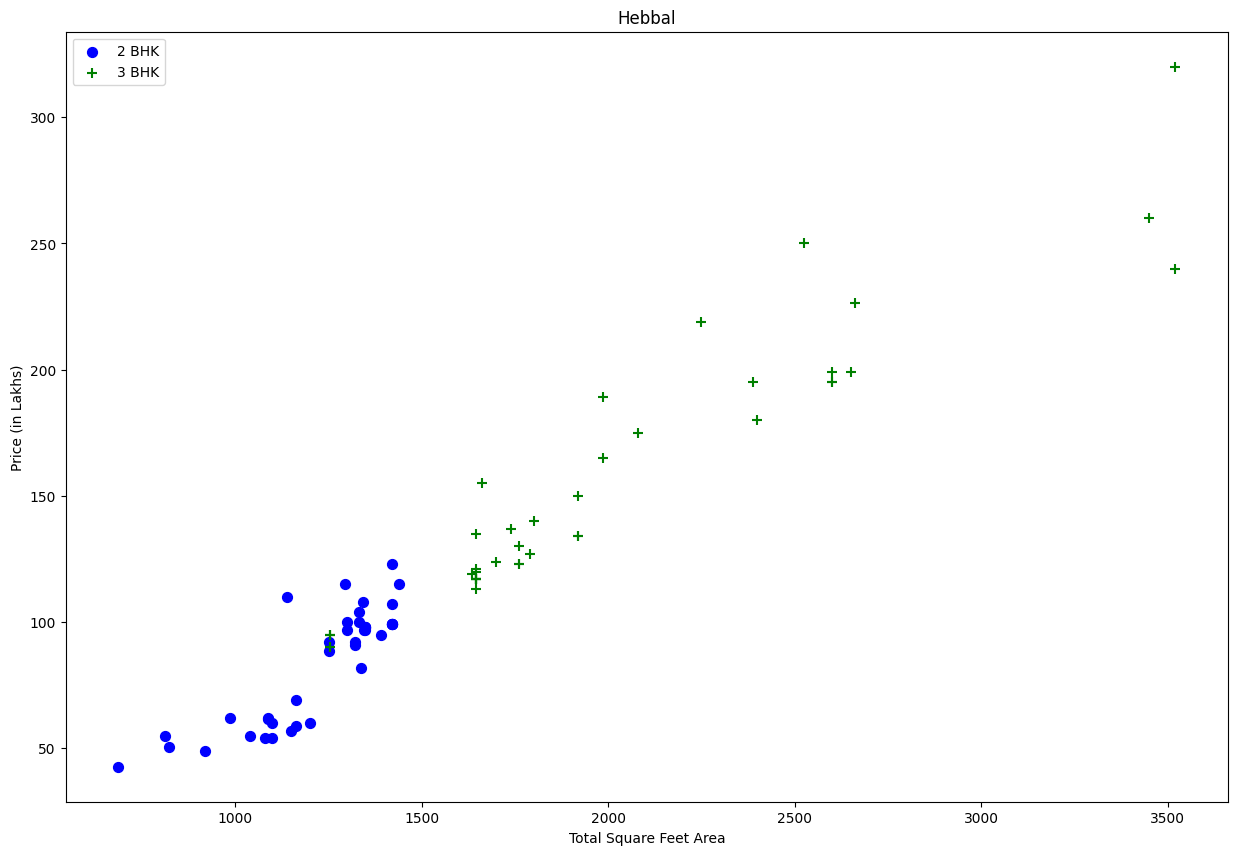

In [96]:
plot_scatter_chart(df4, "Hebbal")

Text(0, 0.5, 'Count')

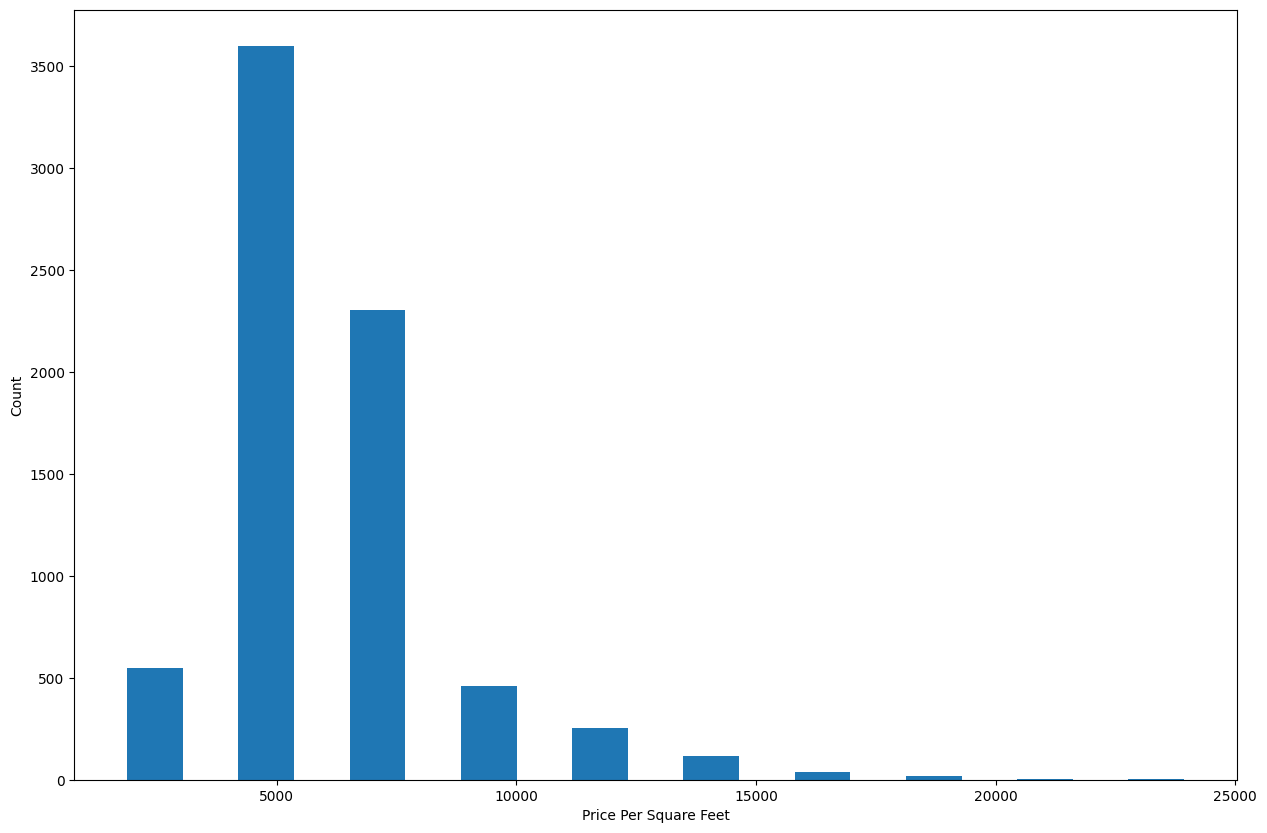

In [97]:
plt.hist(df4.price_per_sqft, rwidth=0.5)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

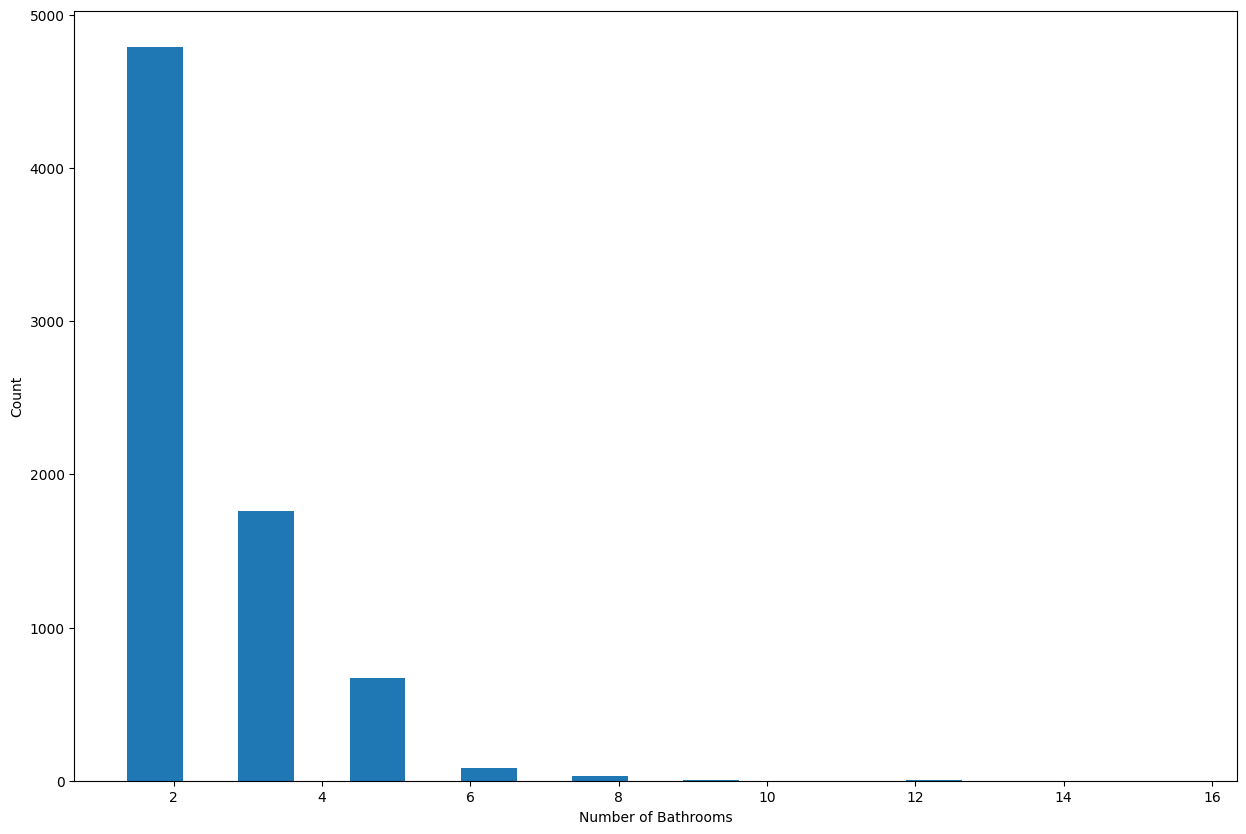

In [98]:
plt.hist(df4.bath, rwidth=0.5)
plt.xlabel("Number of Bathrooms")
plt.ylabel("Count")

In [99]:
# Removing the rows that have "bath" greater than "bhk"+2
df5 = df4[df4.bath<(df4.bhk+2)]
print(len(df4), len(df5))

7342 7264


In [100]:
df5.head()

,area_type,availability,location,bath,balcony,price,bhk,new_total_sqft,price_per_sqft
0,Super built-up Area,Not Ready,1st Block Jayanagar,4.0,1.0,428.0,4,2850.0,15017.543860
1,Super built-up Area,Not Ready,1st Block Jayanagar,3.0,2.0,194.0,3,1630.0,11901.840491
2,Super built-up Area,Ready To Move,1st Block Jayanagar,2.0,3.0,235.0,3,1875.0,12533.333333
3,Built-up Area,Not Ready,1st Block Jayanagar,2.0,0.0,130.0,3,1200.0,10833.333333
4,Super built-up Area,Not Ready,1st Block Jayanagar,2.0,2.0,148.0,2,1235.0,11983.805668


## Model Building

In [101]:
# Removing the unnecessary columns (columns that were added only for removing the outliers)
df6 = df5.copy()
df6 = df6.drop("price_per_sqft", axis="columns")

In [102]:
df6.head()

,area_type,availability,location,bath,balcony,price,bhk,new_total_sqft
0,Super built-up Area,Not Ready,1st Block Jayanagar,4.0,1.0,428.0,4,2850.0
1,Super built-up Area,Not Ready,1st Block Jayanagar,3.0,2.0,194.0,3,1630.0
2,Super built-up Area,Ready To Move,1st Block Jayanagar,2.0,3.0,235.0,3,1875.0
3,Built-up Area,Not Ready,1st Block Jayanagar,2.0,0.0,130.0,3,1200.0
4,Super built-up Area,Not Ready,1st Block Jayanagar,2.0,2.0,148.0,2,1235.0


In [103]:
# Converting the categorical_value into numerical_values using get_dummies method
dummy_cols = pd.get_dummies(df6.location).drop("other", axis="columns")
df6 = pd.concat([df6,dummy_cols], axis="columns")

In [104]:
# Converting the categorical_value into numerical_values using get_dummies method
dummy_cols = pd.get_dummies(df6.availability).drop("Not Ready", axis="columns")
df6 = pd.concat([df6,dummy_cols], axis="columns")

In [105]:
# Converting the categorical_value into numerical_values using get_dummies method
dummy_cols = pd.get_dummies(df6.area_type).drop("Super built-up  Area", axis="columns")
df6 = pd.concat([df6,dummy_cols], axis="columns")

In [106]:
df6.drop(["area_type","availability","location"], axis="columns", inplace=True)
df6.head()

,bath,balcony,price,bhk,new_total_sqft,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,Ready To Move,Built-up Area,Carpet Area,Plot Area
0,4.0,1.0,428.0,4,2850.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3.0,2.0,194.0,3,1630.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2.0,3.0,235.0,3,1875.0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,2.0,0.0,130.0,3,1200.0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,2.0,2.0,148.0,2,1235.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [107]:
# Size of the dataset
df6.shape

(7264, 249)

In [108]:
# Splitting the dataset into features and label
X = df6.drop("price", axis="columns")
y = df6["price"]

In [113]:
# Creating a function for GridSearchCV

def find_best_model(X,y):
    models = {
        "linear_regression": {
            "model": LinearRegression(),
            "parameters": {
                "positive": [True,False]
            }
        },
        
        "lasso": {
            "model": Lasso(),
            "parameters": {
                "alpha": [1,2],
                "selection": ["random", "cyclic"]
            }
        },
        
        "decision_tree": {
            "model": DecisionTreeRegressor(),
            "parameters": {
                "criterion": ["mse", "friedman_mse"],
                "splitter": ["best", "random"]
            }
        }
    }
    
    scores = []
    cv_X_y = ShuffleSplit(n_splits=5, test_size=0.20, random_state=0)
    
    for model_name, model_params in models.items():
        gs = GridSearchCV(model_params["model"], model_params["parameters"], cv=cv_X_y, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            "model": model_name,
            "best_parameters": gs.best_params_,
            "accuracy": gs.best_score_
        })
        
    return pd.DataFrame(scores, columns=["model", "best_parameters", "accuracy"])

find_best_model(X, y)

c:\Users\Yogesh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Yogesh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Yogesh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py", line 1247, in fit
    super().fit(
  File "c:\Users\Yogesh\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.

,model,best_parameters,accuracy
0,linear_regression,{'positive': False},0.820724
1,lasso,"{'alpha': 1, 'selection': 'cyclic'}",0.664476
2,decision_tree,"{'criterion': 'friedman_mse', 'splitter': 'ran...",0.669919


#### Since the Linear Regression has the highest accuracy, the model selected for this problem is Linear Regression

In [ ]:
# Splitting the dataset into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=20)

In [ ]:
# Creating Linear Regression Model
from sklearn.linear_model import LinearRegression
model = LinearRegression(normalize=True)
model.fit(X_train, y_train)

In [ ]:
model.score(X_test, y_test)

#### Predicting the values using our trained model

In [ ]:
X.columns

In [ ]:
# For finding the appropriate location
np.where(X.columns=="2nd Phase Judicial Layout")[0][0]

In [ ]:
# For finding the appropriate area_type
np.where(X.columns=="Built-up  Area")[0][0]

In [ ]:
# For finding the appropriate availability
np.where(X.columns=="Ready To Move")[0][0]

In [ ]:
# Creating a fuction to predict values
def prediction(location, bhk, bath, balcony, sqft, area_type, availability):
    
    loc_index, area_index, avail_index = -1,-1,-1
        
    if location!="other":
        loc_index = int(np.where(X.columns==location)[0][0])
    
    if area_type!="Super built-up  Area":
        area_index = np.where(X.columns==area_type)[0][0]
        
    if availability!="Not Ready":        
        avail_index = np.where(X.columns==availability)[0][0]
            
    x = np.zeros(len(X.columns))
    x[0] = bath
    x[1] = balcony
    x[2] = bhk
    x[3] = sqft
    
    if loc_index >= 0:
        x[loc_index] = 1
    if area_index >= 0:
        x[area_index] = 1
    if avail_index >= 0:
        x[avail_index] = 1
        
    return model.predict([x])[0]

In [ ]:
# Prediction 1
# Input in the form : Location, BHK, Bath, Balcony, Sqft, area_type, availability.
prediction("1st Block Jayanagar", 2, 2, 2, 1000, "Built-up  Area", "Ready To Move")

In [ ]:
# Prediction 2
# Input in the form : Location, BHK, Bath, Balcony, Sqft, area_type, availability.
prediction("1st Phase JP Nagar", 2, 2, 2, 1000, "Super built-up  Area", "Ready To Move")

In [ ]:
# Prediction 3
# Input in the form : Location, BHK, Bath, Balcony, Sqft, area_type, availability.
prediction("1st Phase JP Nagar", 2, 3, 2, 2000, "Plot  Area", "Not Ready")